📈 Próg anomalii (95. percentyl): 0.0034


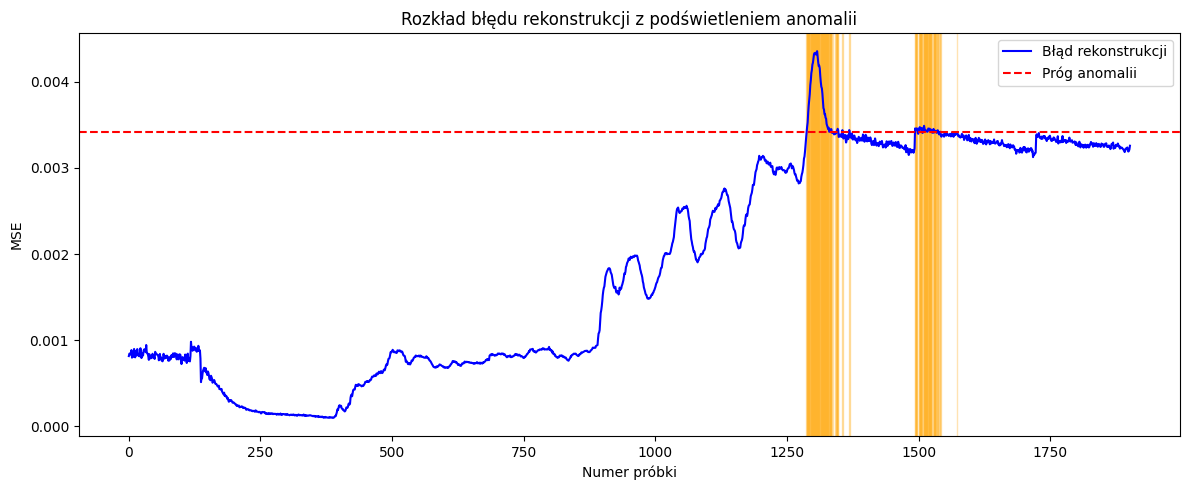

✅ Zapisano raport do pliku: anomaly_results_on_test_data/anomaly_report.csv


In [1]:
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# === KONFIGURACJA ===
IMAGE_DIR = "output_rois/test_roi_weld"   # folder z danymi do testu
MODEL_PATH = "autoencoder.pth"            # ścieżka do zapisanego modelu
OUTPUT_DIR = "anomaly_results_on_test_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = (64, 64)

# === TRANSFORMACJA OBRAZÓW ===
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()  # [0,1]
])

# === DATASET ===
class WeldDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.files = sorted(glob.glob(os.path.join(folder, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

# === STRUKTURA AUTOENCODERA ===
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1), torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1), torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1), torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

# === WCZYTANIE MODELU ===
model = ConvAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# === DETEKCJA ANOMALII ===
dataset = WeldDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

errors = []
filenames = []

with torch.no_grad():
    for img, fname in dataloader:
        img = img.to(DEVICE)
        recon = model(img)
        loss = F.mse_loss(recon, img).item()
        errors.append(loss)
        filenames.append(fname[0])

# === PROG ANOMALII ===
threshold = np.percentile(errors, 95)
print(f"📈 Próg anomalii (95. percentyl): {threshold:.4f}")

# === ZAPIS HEATMAP DLA ANOMALII ===
for i, (error, fname) in enumerate(zip(errors, filenames)):
    if error < threshold:
        continue

    img = dataset[i][0]
    input_tensor = img.unsqueeze(0).to(DEVICE)
    recon = model(input_tensor).cpu().squeeze()
    diff = torch.abs(img.squeeze() - recon)

    plt.imshow(diff.detach().cpu().numpy(), cmap='hot')
    plt.title(f"Anomalia: {fname}\nMSE: {error:.4f}")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"anomaly_{fname}.png"))
    plt.close()

# === WYKRES BŁĘDU Z PODŚWIETLENIEM ANOMALII ===
errors_np = np.array(errors)
x = np.arange(len(errors_np))
anomaly_indices = np.where(errors_np > threshold)[0]

plt.figure(figsize=(12, 5))
plt.plot(x, errors_np, label='Błąd rekonstrukcji', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Próg anomalii')
for idx in anomaly_indices:
    plt.axvspan(idx - 0.5, idx + 0.5, color='orange', alpha=0.3)
plt.title("Rozkład błędu rekonstrukcji z podświetleniem anomalii")
plt.xlabel("Numer próbki")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "highlighted_anomalies.png"))
plt.show()

# === ZAPIS DO CSV ===
csv_path = os.path.join(OUTPUT_DIR, "anomaly_report.csv")
with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["filename", "mse", "anomaly"])
    for fname, err in zip(filenames, errors):
        writer.writerow([fname, f"{err:.6f}", int(err > threshold)])

print(f"✅ Zapisano raport do pliku: {csv_path}")
